# Data Dragons

## Import Libraries

In [1]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)

In [2]:
cd = os.getcwd()
data_path = os.path.join(cd,'Data files')
subset_path = os.path.join(cd,'Random subset of data files')

variable_list = pd.read_csv(os.path.join(cd,'Documentation/variable_list.csv'),encoding='latin-1')
codebook = pd.read_csv(os.path.join(cd,'Documentation/codebook.csv'))

# page_views_df = pd.read_csv(os.path.join(subset_path,'page_views.csv'))
# responses_df = pd.read_csv(os.path.join(subset_path,'responses.csv'))
# items_df = pd.read_csv(os.path.join(subset_path,'items.csv'))
# media_views_df = pd.read_csv(os.path.join(subset_path, 'media_views.csv'))
# checkpoints_df = pd.read_csv(os.path.join(subset_path, 'checkpoints.csv'))

In [3]:
page_views_df = pd.read_csv(os.path.join(data_path,'page_views.csv'))
# responses_df = pd.read_csv(os.path.join(data_path,'responses.csv'))
items_df = pd.read_csv(os.path.join(data_path,'items.csv'))
# media_views_df = pd.read_csv(os.path.join(data_path,'media_views.csv'))
checkpoints_df = pd.read_csv(os.path.join(data_path,'checkpoints.csv'))

/var/folders/rb/yl_gwgt51rggw0ydvv3ksqnh0000gn/T/ipykernel_26358/650685091.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  page_views_df = pd.read_csv(os.path.join(data_path,'page_views.csv'))


## Data

items, media views, page views, responses, checkpoints datasets

The labels ABC or ABCD refer to the content included in the books

Section A refers to the first 4 chapters of the book that include an introduction to R and making data visualizations

Section B refers to the next 5 chapters which focus on modeling variation with simple models (goes up through models that include one predictor variable, e.g., regression and grouping models)

Section C refers to 3 chapters that cover inferential statistics with a modeling approach (hypothesis testing and confidence intervals with and without simulations)

Section D refers to 4 chapters that cover multivariate models (factorial ANOVA, ANCOVA, and multiple regression).

### Learning Items

In [4]:
items_subset = items_df[['lrn_type','chapter_number','section_number','review_flag']]

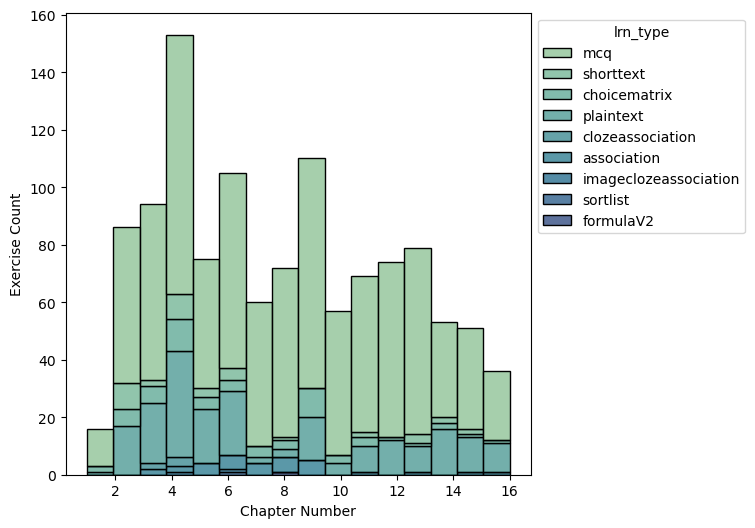

In [5]:
fig, ax = plt.subplots(figsize=(6,6))

g = sns.histplot(data=items_subset, x="chapter_number", hue="lrn_type", bins=16, multiple="stack",palette="crest")
g.set(xlabel="Chapter Number", ylabel='Exercise Count')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

## Analysis

### filter page views
combine page views that are of the same chapter and section, in the same time window remove reduntant pages open at the same time

#### dataframe with of review sections

In [6]:
review_pages = page_views_df[page_views_df.review_flag == True][['chapter_number','section_number']].drop_duplicates().sort_values('chapter_number')

In [7]:
page_views_df.dt_accessed = pd.to_datetime(page_views_df.dt_accessed)

In [8]:
# combine inactive metrics
def idleOff(df):
    df = df.assign(idle=df.idle_brief + df.idle_long)
    df = df.assign(off=df.off_page_brief + df.off_page_long)
    return df

# calculate when page was closed using time engaged and inactive
def dt_closed(df):
    timeDelta = df.engaged + df.idle + df.off
    timeDelta_td = pd.to_timedelta(timeDelta, unit='ms').dt.round('s')
    df = df.assign(t_delta=timeDelta)
    df = df.assign(dt_closed=(df.dt_accessed+timeDelta_td))
    return df

#only use pages with EOC
page_views_filtered = (
    page_views_df[~page_views_df.chapter_number.isna()]
    .pipe(idleOff)
    .pipe(dt_closed)
    .drop(columns=['release','chapter','page','institution_id','class_id','was_complete', 'tried_again_dt', 'tried_again_clicks', 'review_flag', 'idle_brief','idle_long','off_page_brief','off_page_long'])
    .reindex(columns=['book','student_id','chapter_number','section_number','dt_accessed','dt_closed','engaged','idle','off','t_delta'])
    .dropna()
    .reset_index(drop=True)
    )

In [9]:
# Function to merge overlapping intervals and sum columns
def merge_intervals_and_sum(df):

    merged = []
    
    # Group by student_id, chapter_number, section_number
    for (student_id, chapter_number, section_number), group in df.groupby(['student_id', 'chapter_number', 'section_number']):
        group = group.sort_values(by='dt_accessed')
        current_start = group.iloc[0]['dt_accessed']
        current_end = group.iloc[0]['dt_closed']
        total_engaged = group.iloc[0]['engaged']
        
        # Loop through the group
        for i in range(1, len(group)):
            start = group.iloc[i]['dt_accessed']
            end = group.iloc[i]['dt_closed']
            engaged = group.iloc[i]['engaged']
            
            # Check if intervals overlap
            if start <= current_end:
                # Merge intervals and sum engaged, idle, off times
                current_end = max(current_end, end)
                total_engaged += engaged

            else:
                # No overlap, add current interval to merged and move to the next one
                merged.append([student_id, chapter_number, section_number, current_start, current_end, total_engaged])
                current_start = start
                current_end = end
                total_engaged = engaged
        
        # Append the last merged interval
        merged.append([student_id, chapter_number, section_number, current_start, current_end, total_engaged])
    
    return pd.DataFrame(merged, columns=['student_id', 'chapter_number', 'section_number', 'dt_accessed', 'dt_closed', 'engaged'])

In [10]:
page_views_filtered = merge_intervals_and_sum(page_views_filtered)
page_views_filtered['time_window'] = page_views_filtered.dt_closed - page_views_filtered.dt_accessed
page_views_filtered.engaged = pd.to_timedelta(page_views_filtered.engaged, unit='ms').dt.round('s')

#### analyze students' study habits, proportion of how much they spent on pages not review pages

In [11]:
study_df = page_views_filtered.merge(review_pages, on=['chapter_number', 'section_number'], how='left', indicator=True)
study_df = study_df[study_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [12]:
section_engagement_df = study_df.groupby(by=['student_id','chapter_number','section_number']).agg({'engaged':'sum'}).reset_index()
total_engagement_df = study_df.groupby(by=['student_id','chapter_number']).agg({'engaged':'sum'}).reset_index().rename(columns={'engaged':'total_engaged'})

engage_prop_df = pd.merge(section_engagement_df, total_engagement_df, on=['student_id', 'chapter_number'])

engage_prop_df['engaged_prop'] = engage_prop_df.engaged/engage_prop_df.total_engaged

In [13]:
engage_prop_df = engage_prop_df.pivot(index='student_id',columns=['chapter_number','section_number'],values='engaged_prop')

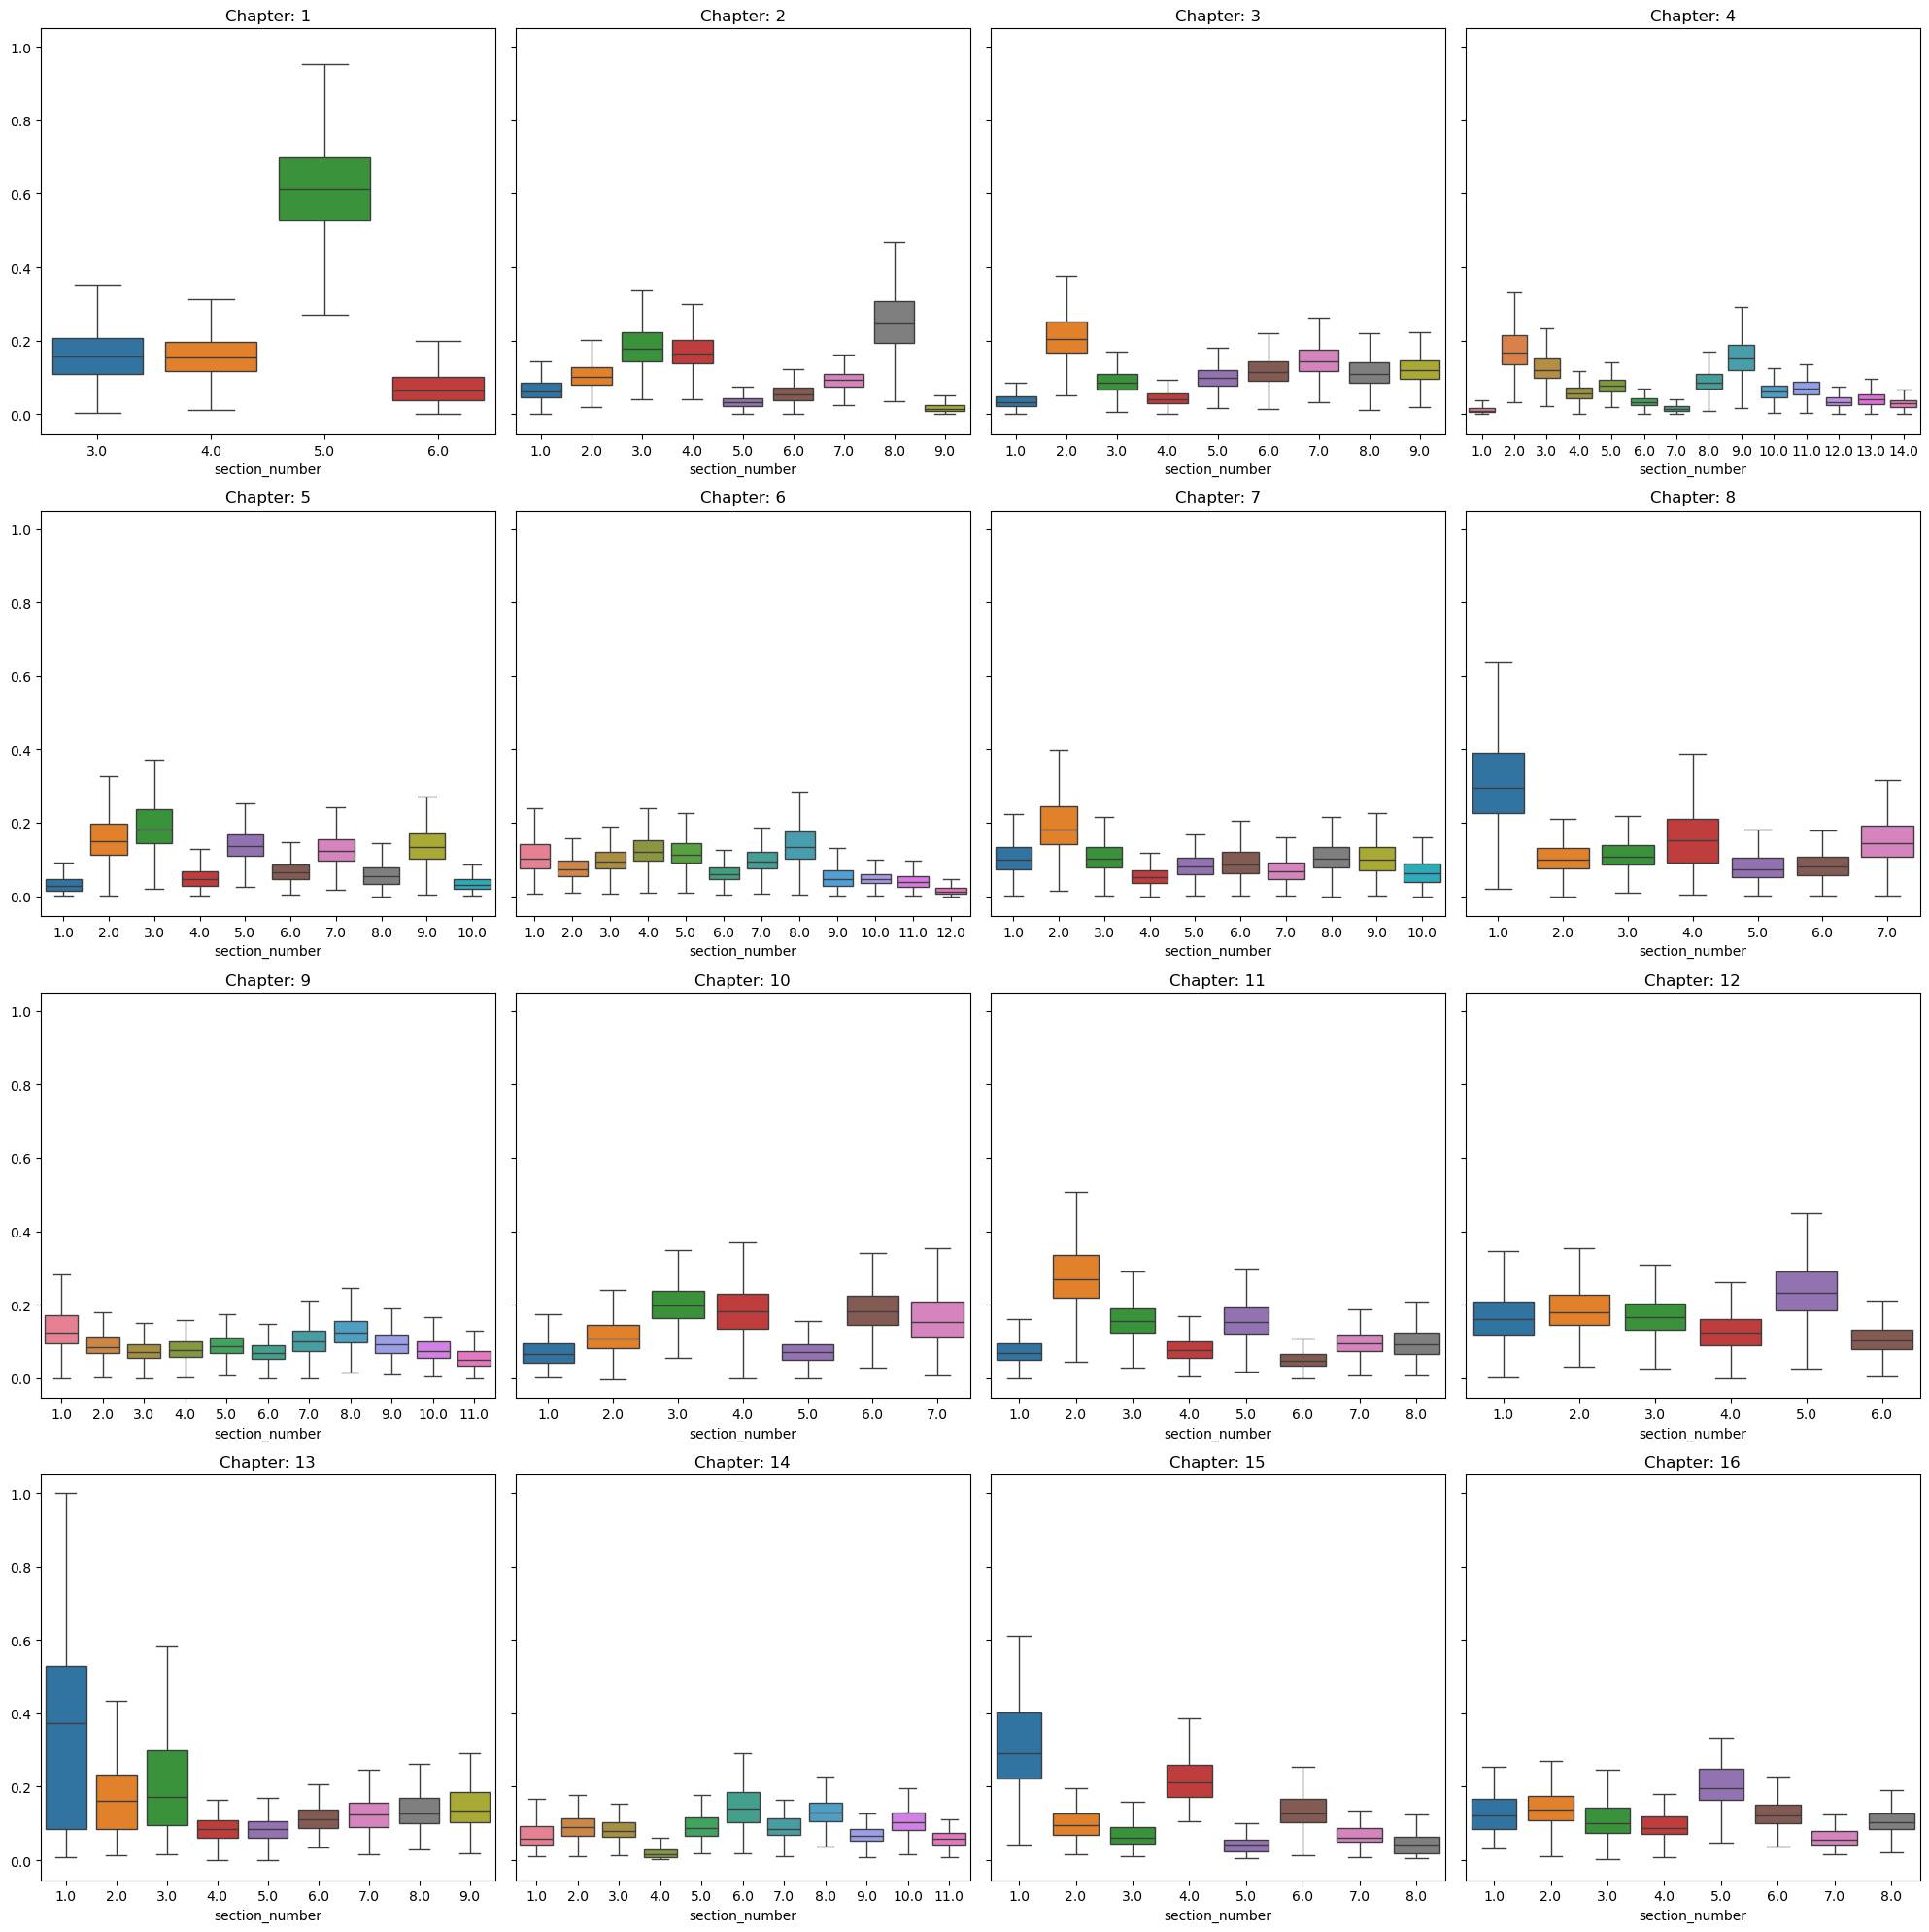

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)

for i in range(1,17):
    row, col = divmod(i-1, 4)
    sns.boxplot(data=engage_prop_df[i], ax=axes[row, col], showfliers=False)
    axes[row, col].set_title(f'Chapter: {i}')
plt.tight_layout()
plt.show()

#### analyze performance using checkpoints

In [15]:
def AR(df):
    df = df.assign(AR = df.n_attempt / df.n_possible)
    return df

performance_df = (
    checkpoints_df
    .pipe(AR)
    .drop(columns=['book','release','institution_id','class_id','response','construct','n_possible','n_correct','n_attempt'])
    .drop_duplicates(subset=['student_id','chapter_number'])
    .dropna(subset='EOC')
)

#### performance vis

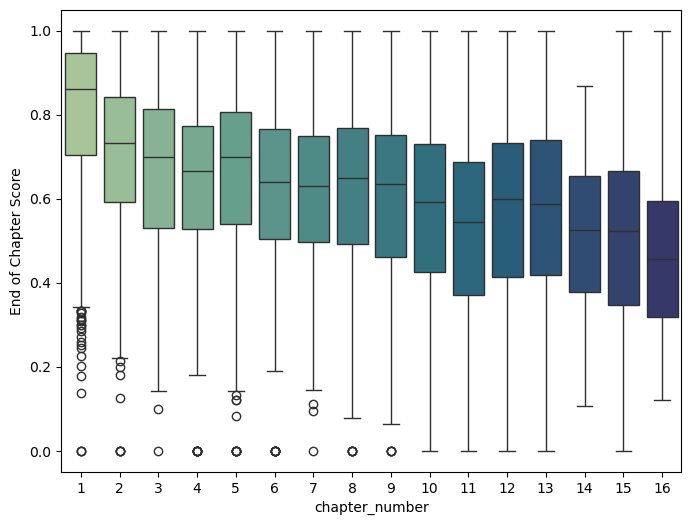

In [16]:
plt.figure(figsize=(8,6))
fig = sns.boxplot(data=performance_df, x='chapter_number', y='EOC', hue='chapter_number', palette="crest", legend=False)
fig.set(ylabel='End of Chapter Score')
plt.show()

#### attempt vis

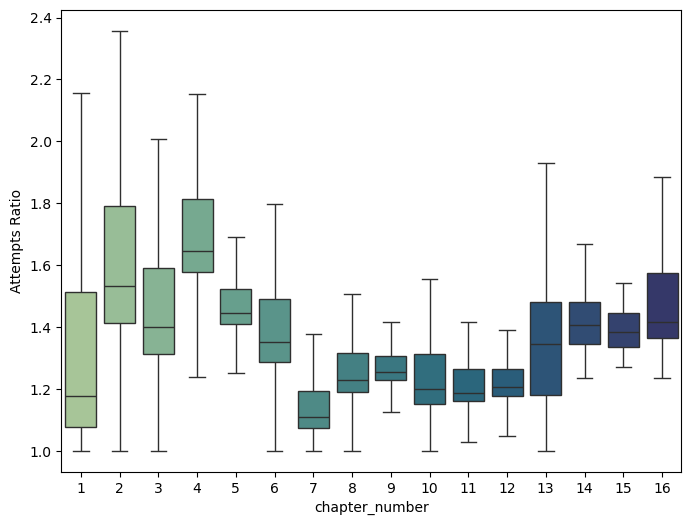

In [17]:
plt.figure(figsize=(8,6))
fig = sns.boxplot(data=performance_df, x='chapter_number', y='AR', hue='chapter_number', palette='crest', showfliers=False, legend=False)
fig.set(ylabel='Attempts Ratio')
plt.show()

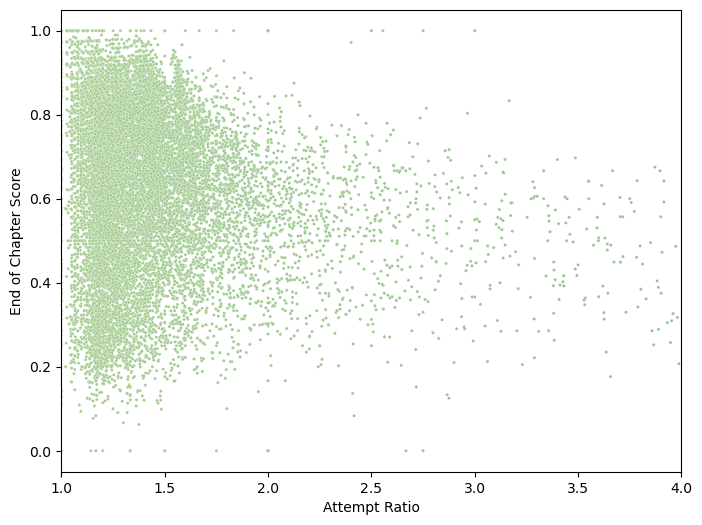

In [18]:
plt.figure(figsize=(8,6))
g = sns.scatterplot(data=performance_df, x='AR', y='EOC', s=5, hue='AR', palette='crest', legend=False)
g.set(xlabel='Attempt Ratio', ylabel='End of Chapter Score')
plt.xlim((1,4))
plt.show()

In [19]:
performance_df = performance_df.pivot(index='student_id', columns='chapter_number', values=['EOC','AR']).swaplevel(axis=1)

In [20]:
df = engage_prop_df.join(performance_df, how='left')

In [76]:
i = 16
X = df[i].dropna(subset=['EOC']).fillna(0)

In [77]:
X_train = X.loc[:, (X.columns != 'AR')]
y_train = X[['EOC']]
X_train.columns = X_train.columns.astype('string')

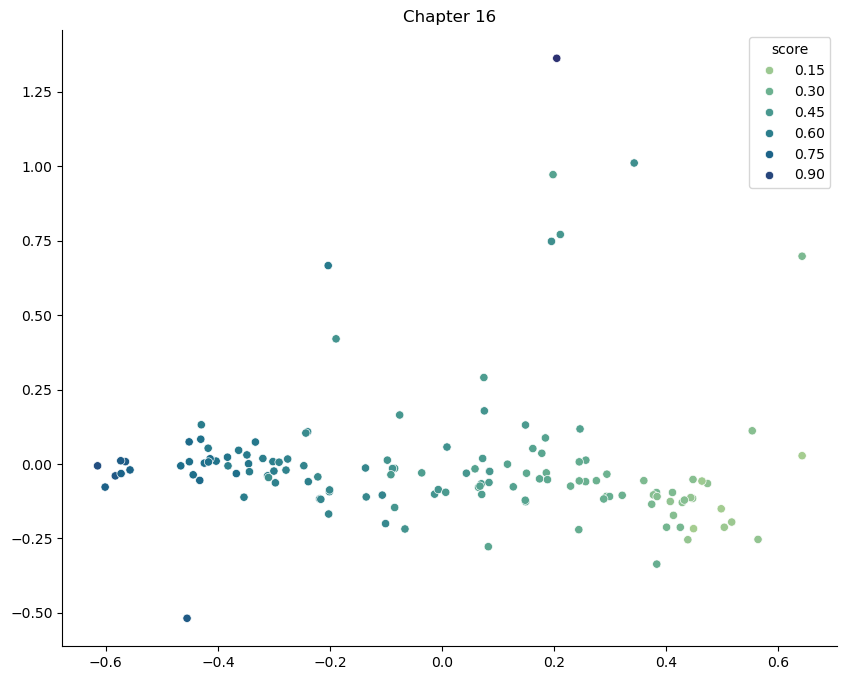

In [78]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X_train)

iso_df = pd.DataFrame(data=X_transformed, columns=['1','2'])
iso_df = iso_df.set_index(X_train.index)
iso_df['score'] = y_train

plt.figure(figsize=(10,8))
sns.scatterplot(data=iso_df, x='1', y='2', hue='score', palette='crest')

sns.despine()

plt.xlabel('')
plt.ylabel('')

plt.title(f"Chapter {i}")

plt.show()

#### Visualization

In [177]:
performance_df = (
    page_views_filtered
    .merge(right=review_pages, on=['chapter_number','section_number'], how="inner")
    .merge(right=page_views_df[['student_id','book','chapter_number']].drop_duplicates(), on=['student_id', 'chapter_number'], how='left')
    )

In [66]:
review_count = performance_df.groupby(by=['book','student_id','chapter_number']).size().reset_index(name='row_count')

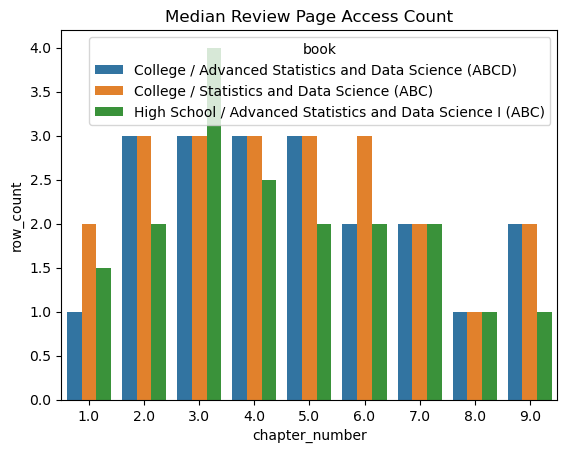

In [29]:
sns.barplot(data=review_count, x='chapter_number', y='row_count', hue='book', estimator=np.median, errorbar=('ci', False))
plt.title("Median Review Page Access Count")
plt.show()

In [13]:
def attemptConvert(df):
    df = df.assign(attempt=df.n_attempt/df.n_possible)
    return df

checkpoints_filtered = (
    checkpoints_df
    .drop(columns=['book','release','institution_id','class_id','response','construct'])
    .dropna()
    .drop_duplicates()
    .pipe(attemptConvert)
    .drop(columns=['n_possible', 'n_correct', 'n_attempt'])
    )

In [14]:
combined_df = checkpoints_filtered.merge(right=page_views_filtered, on=['student_id','chapter_number'], how='left')

In [11]:
combined_df = combined_df.drop(columns=['section_number'])

In [12]:
total_time = combined_df.engaged + combined_df.idle_brief + combined_df.idle_long + combined_df.off_page_brief + combined_df.off_page_long

combined_df.engaged = combined_df.engaged/total_time
combined_df.idle_brief = combined_df.idle_brief/total_time
combined_df.idle_long = combined_df.idle_long/total_time
combined_df.off_page_brief = combined_df.off_page_brief/total_time
combined_df.off_page_long = combined_df.off_page_long/total_time

In [13]:
combined_df = combined_df.dropna()

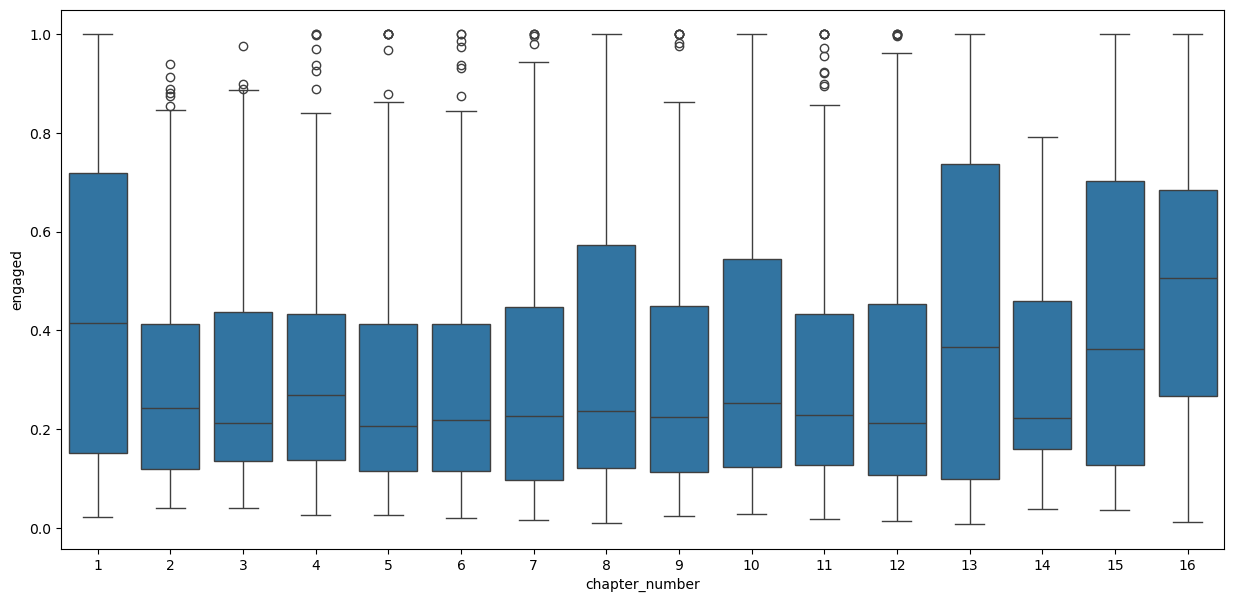

In [14]:
plt.figure(figsize=(15,7))
sns.boxplot(data=combined_df, x='chapter_number', y='engaged')
plt.show()

In [18]:
X_train = combined_df[['attempt','engaged','idle_brief','idle_long','off_page_brief','off_page_long','EOC']]
y_train = combined_df[['EOC']]

In [157]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train,y_train)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
pca_df['chapter'] = combined_df['chapter_number']

plt.figure(figsize=(15,10))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='chapter')
plt.xscale('log')
plt.show()

In [27]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=25).fit_transform(X_train)
X_embedded.shape

(2473, 2)

In [28]:
tsne_df = pd.DataFrame(data=X_embedded, columns=['Component 1','Component 2'])
tsne_df['chapter'] = combined_df['chapter_number']

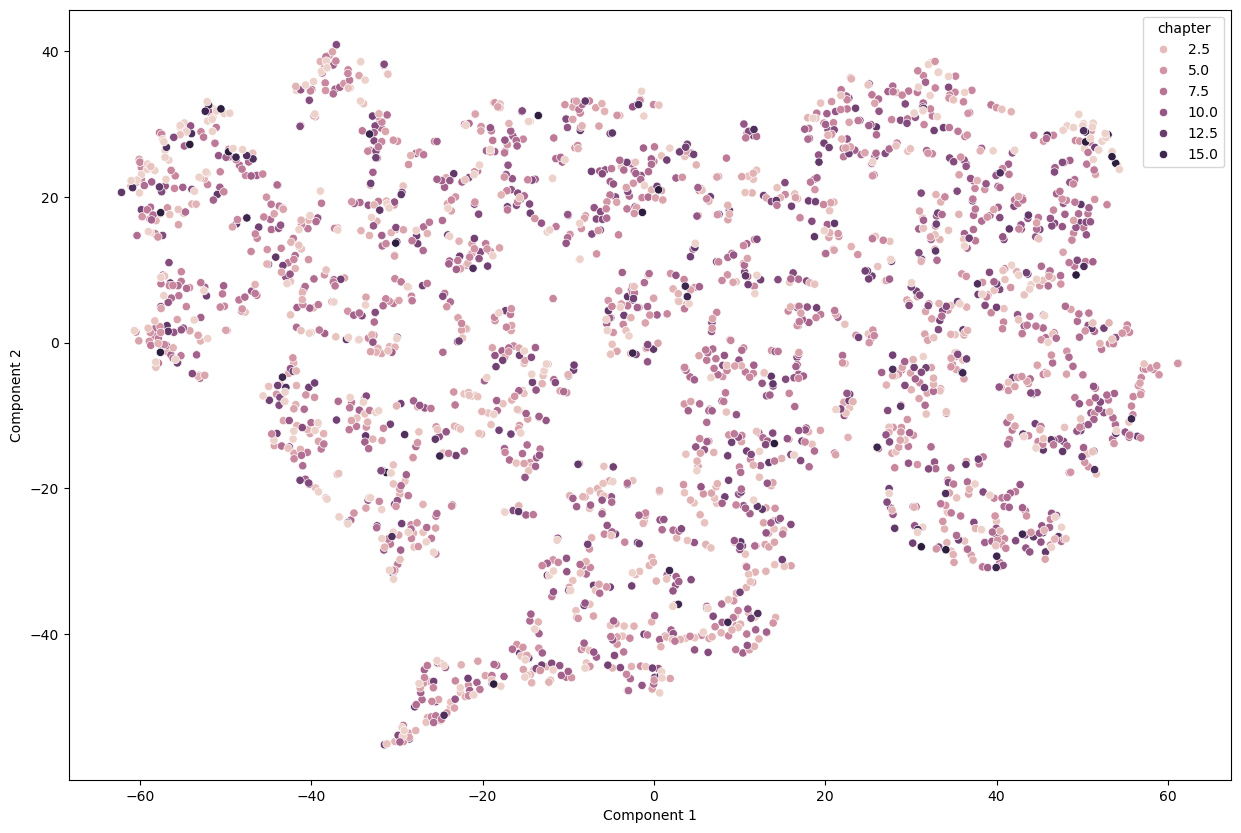

In [31]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=tsne_df, x='Component 1', y='Component 2', hue='chapter')
plt.show()